Saving aga02.jpg to aga02 (4).jpg
Epoch 0/50 - Loss: 0.10532844066619873
Epoch 10/50 - Loss: 0.07181346416473389
Epoch 20/50 - Loss: 0.05142083764076233
Epoch 30/50 - Loss: 0.057464711368083954
Epoch 40/50 - Loss: 0.04752088710665703


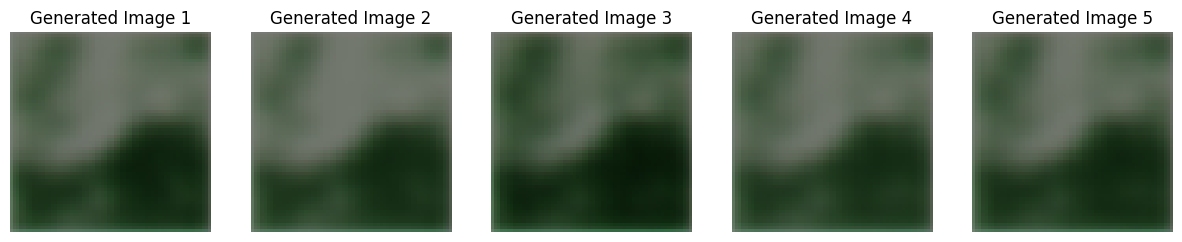

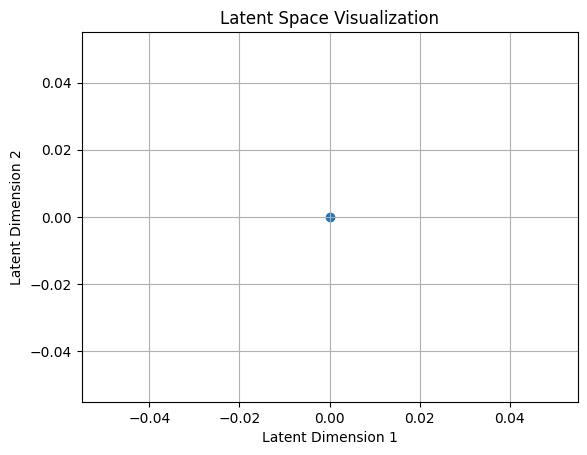

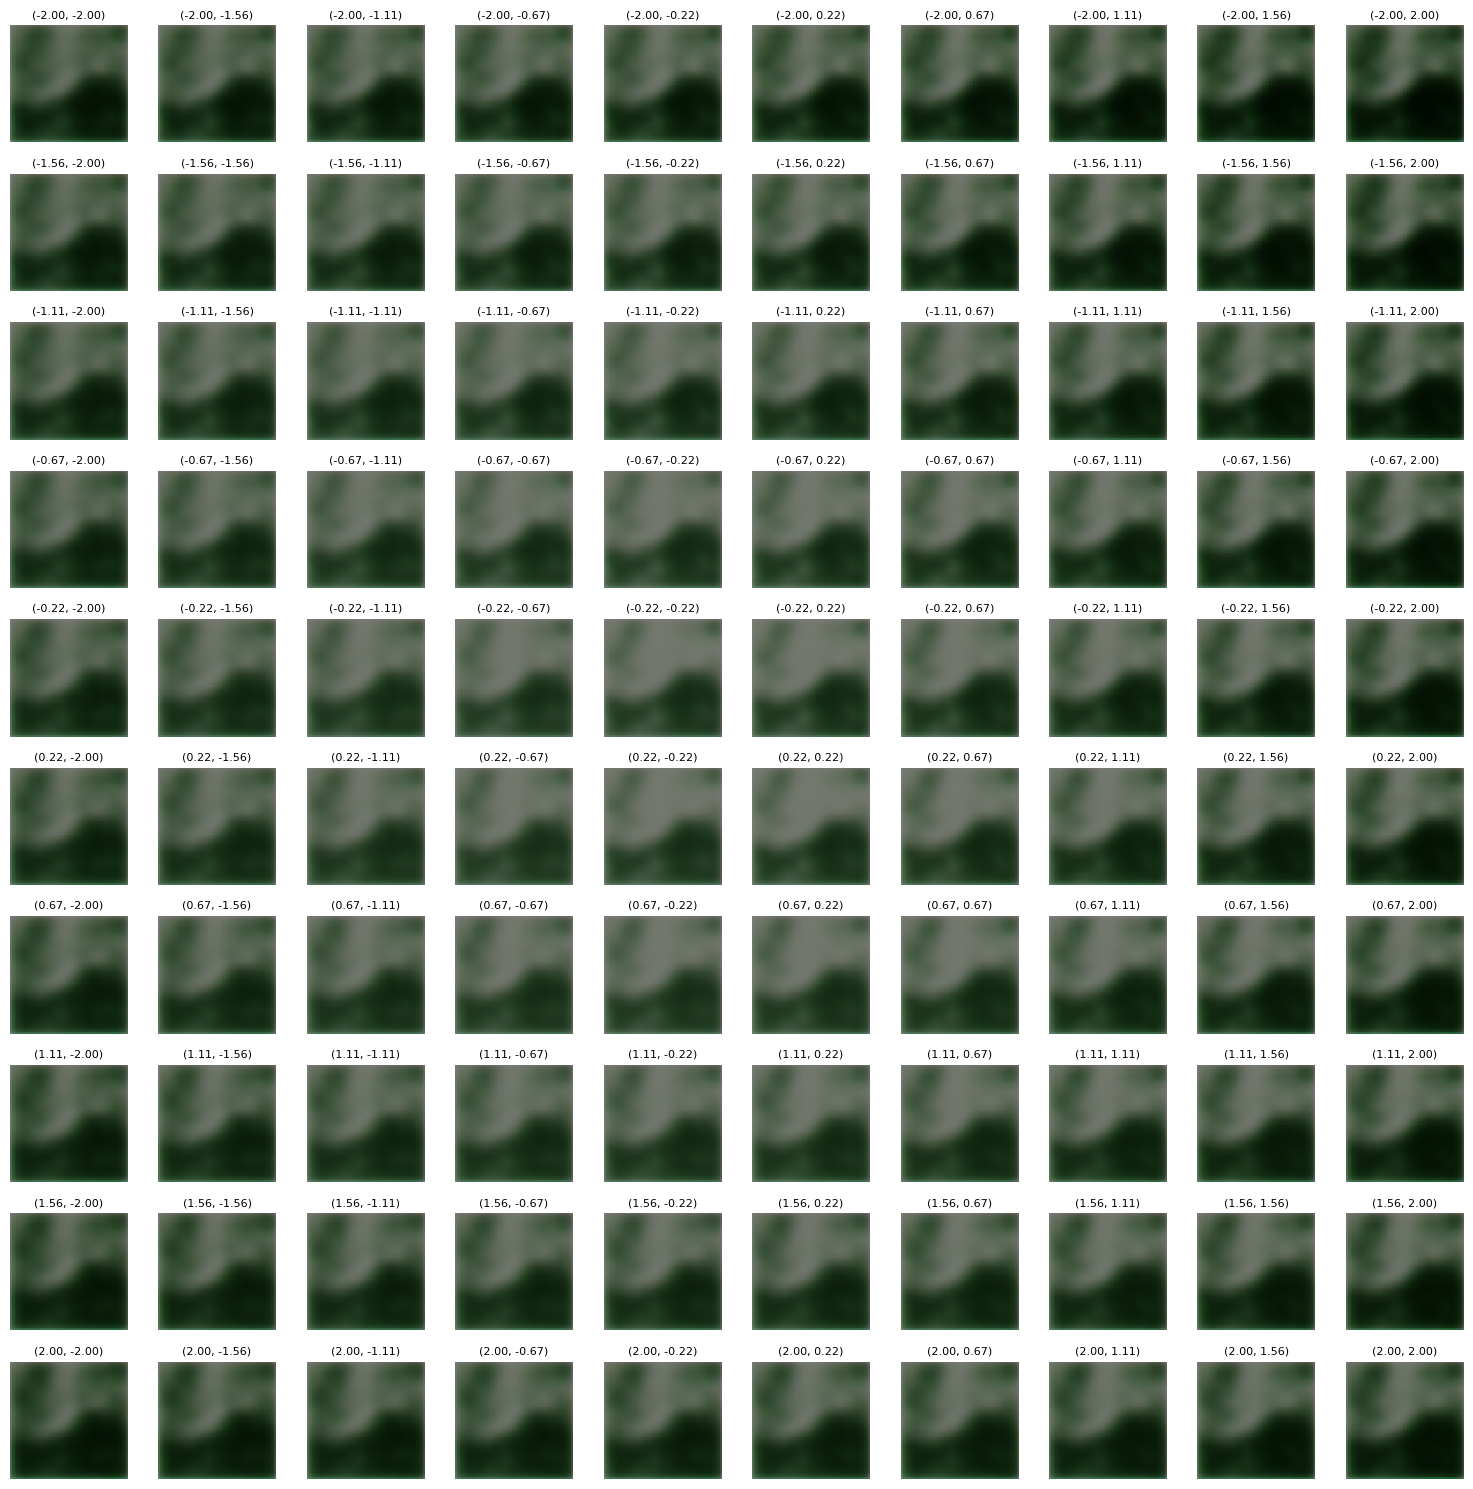

In [9]:
from google.colab import files
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

img_path = next(iter(uploaded))
img = image.load_img(img_path, target_size=(64, 64))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0

class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(64, 64, 3)),
            layers.Conv2D(32, 3, activation='relu', padding='same'),
            layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
            layers.Conv2D(64, 3, activation='relu', padding='same'),
            layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.Flatten(),
            layers.Dense(128, activation='relu')
        ])

        self.z_mean = layers.Dense(self.latent_dim)
        self.z_log_var = layers.Dense(self.latent_dim)

        self.decoder_hid = layers.Dense(16 * 16 * 128, activation='relu')
        self.decoder_reshape = layers.Reshape((16, 16, 128))
        self.decoder_conv1 = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')
        self.decoder_upsample1 = layers.UpSampling2D(size=(2, 2))
        self.decoder_conv2 = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')
        self.decoder_upsample2 = layers.UpSampling2D(size=(2, 2))
        self.decoder_output = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')

    def call(self, inputs):
        x = self.encoder(inputs)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)

        batch = tf.shape(inputs)[0]
        epsilon = tf.random.normal(shape=(batch, self.latent_dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

        x = self.decoder_hid(z)
        x = self.decoder_reshape(x)
        x = self.decoder_conv1(x)
        x = self.decoder_upsample1(x)
        x = self.decoder_conv2(x)
        x = self.decoder_upsample2(x)
        decoded = self.decoder_output(x)

        return decoded, z_mean, z_log_var

def vae_loss(y_true, y_pred, z_mean, z_log_var):
    mse_loss = tf.keras.losses.MeanSquaredError()
    reconstruction_loss = tf.reduce_mean(mse_loss(y_true, y_pred))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
    return reconstruction_loss + kl_loss


latent_dim = 2
vae = VAE(latent_dim)

def train_step(model, img, optimizer):
    with tf.GradientTape() as tape:
        decoded, z_mean, z_log_var = model(img)
        loss = vae_loss(img, decoded, z_mean, z_log_var)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

epochs = 50
for epoch in range(epochs):
    loss = train_step(vae, img, optimizer)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.numpy()}")

def generate_images(vae, num_images=5):
    random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
    generated_images = vae.decoder_hid(random_latent_vectors)
    generated_images = vae.decoder_reshape(generated_images)
    generated_images = vae.decoder_conv1(generated_images)
    generated_images = vae.decoder_upsample1(generated_images)
    generated_images = vae.decoder_conv2(generated_images)
    generated_images = vae.decoder_upsample2(generated_images)
    generated_images = vae.decoder_output(generated_images)
    return generated_images

generated_images = generate_images(vae, num_images=5)

plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(generated_images[i])
    plt.axis('off')
    plt.title(f"Generated Image {i+1}")
plt.show()

encoded_imgs = vae.encoder(img)
encoded_img = encoded_imgs[0].numpy()

plt.scatter(encoded_img[0], encoded_img[1])
plt.title("Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()

def plot_latent_space(vae, grid_size=10, show=True):
    figure, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    grid_latent_vectors = np.linspace(-2, 2, grid_size)

    for i in range(grid_size):
        for j in range(grid_size):
            latent_vector = np.array([[grid_latent_vectors[i], grid_latent_vectors[j]]])
            generated_img = vae.decoder_hid(latent_vector)
            generated_img = vae.decoder_reshape(generated_img)
            generated_img = vae.decoder_conv1(generated_img)
            generated_img = vae.decoder_upsample1(generated_img)
            generated_img = vae.decoder_conv2(generated_img)
            generated_img = vae.decoder_upsample2(generated_img)
            generated_img = vae.decoder_output(generated_img)

            axes[i, j].imshow(generated_img[0].numpy())
            axes[i, j].axis('off')
            axes[i, j].set_title(f"({grid_latent_vectors[i]:.2f}, {grid_latent_vectors[j]:.2f})", fontsize=8)

    if show:
        plt.tight_layout()
        plt.show()

plot_latent_space(vae, grid_size=10)
